## Import ##

In [153]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, activations
import matplotlib.pyplot as plt
from model_profiler import model_profiler
import pathlib
from pathlib import Path
import cv2 as cv
import json
import pandas as pd
import nvidia_smi
from numba import cuda

batch_size = 250
epoch_size = 10000

In [154]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def get_txt_data(path: Path) -> np.ndarray:
    with path.open("r", encoding="utf-8") as f:
        result: list = json.loads(f.readline())
        return np.array(flatten(result))


# p = pathlib.Path('../../openCV_python/data/out/resized_frames/resized')
# txt_files = list(p.glob('*.txt'))
# img_files = [item.parent.resolve() / item.stem for item in txt_files]
# txt_files[0].stem
# image = txt_files[0].parent.resolve() / txt_files[0].stem

# img_count = len(txt_files)
# img_shape = cv.imread(str(image)).shape

# txt_shape = get_txt_data(txt_files[0]).shape

# input_shape = (img_count, *img_shape)
# output_shape = (img_count, *txt_shape)
input_data: np.ndarray = np.load('data/train_input.npy')
output_data: np.ndarray = np.load('data/train_output.npy')
input_shape = input_data.shape[1:]
output_shape = output_data.shape[1:]
# data = []

# for i in range(len(img_files)):
#     input_data[i] = cv.imread(str(img_files[i]))
#     output_data[i] = get_txt_data(txt_files[i])

print('input shape')
print(input_shape)
print()
print('output shape')
print(output_shape)


def load_data():
    l = len(input_data)
    last = l - 1
    test_len = 10
    first = int(l-l/test_len)
    train_images = input_data[0:first]
    train_labels = output_data[0:first]

    test_images = input_data[first:last]
    test_labels = output_data[first:last]

    return (train_images, train_labels), (test_images, test_labels)


input shape
(59, 40, 3)

output shape
(8,)


In [155]:
(train_images, train_labels), (test_images, test_labels) = load_data()


In [156]:
input_shape = (59, 40, 3)
print(np.prod(input_shape))

normalization = tf.keras.layers.Normalization(axis=None)
normalization.adapt([0,255.0])

model = models.Sequential()
model.add(layers.Input(input_shape))
model.add(normalization)
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(1024, 'relu'))
model.add(layers.Dense(8))

model.summary()


7080
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_16 (Normaliza  (None, 59, 40, 3)        3         
 tion)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 57, 38, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 28, 19, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 26, 17, 32)        9248      
                                                                 
 flatten_16 (Flatten)        (None, 14144)             0         
                                                                 
 dense_48 (Dense)            (None, 1024)       

In [157]:
profile = model_profiler(model, batch_size)

print(profile)


| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0004  | BFLOPs  |
| GPU Memory Requirement           | 0.1278  | GB      |
| Model Parameters                 | 14.5028 | Million |
| Memory Required by Model Weights | 55.3239 | MB      |


d:\projects\ai\tensorflow-test\.conda\lib\site-packages\model_profiler\profiler.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(values).reshape(-1,1),


In [158]:
model.compile(optimizer='adam',
              loss="mae",)

history = model.fit(
    train_images, train_labels,
    epochs=epoch_size,
    batch_size=batch_size,
    validation_data=(test_images, test_labels)
)


Epoch 1/10000
19/19 [==============================] - 1s 17ms/step - loss: 293.8786 - val_loss: 149.5362
Epoch 2/10000
19/19 [==============================] - 0s 12ms/step - loss: 150.3720 - val_loss: 134.8456
Epoch 3/10000
19/19 [==============================] - 0s 13ms/step - loss: 135.6735 - val_loss: 127.9047
Epoch 4/10000
19/19 [==============================] - 0s 12ms/step - loss: 126.5751 - val_loss: 112.5287
Epoch 5/10000
19/19 [==============================] - 0s 13ms/step - loss: 107.3393 - val_loss: 102.6239
Epoch 6/10000
19/19 [==============================] - 0s 13ms/step - loss: 98.2838 - val_loss: 86.8964
Epoch 7/10000
19/19 [==============================] - 0s 13ms/step - loss: 88.6057 - val_loss: 94.5405
Epoch 8/10000
19/19 [==============================] - 0s 13ms/step - loss: 93.9784 - val_loss: 81.3019
Epoch 9/10000
19/19 [==============================] - 0s 13ms/step - loss: 84.8834 - val_loss: 75.3226
Epoch 10/10000
19/19 [==============================] 

KeyboardInterrupt: 

In [ ]:
history: dict = history.history
loss = history['loss']
val_loss = history['val_loss']
l = int(len(loss) / 10)
history['loss'] = loss[l:]
history['val_loss'] = val_loss[l:]


{'loss': [7.805155277252197, 12.1511869430542, 7.130895614624023, 7.994080543518066, 7.883392333984375, 6.135523796081543, 6.232314586639404, 5.8335490226745605, 6.523159980773926, 6.605541706085205, 5.461913108825684, 7.788782119750977, 6.61846399307251, 6.747491836547852, 6.796682834625244, 7.128626346588135, 7.178271770477295, 6.900399208068848, 7.471157550811768, 7.330915927886963, 7.672480583190918, 6.505374908447266, 6.751770496368408, 5.903879642486572, 5.0022430419921875, 5.967799186706543, 6.015125751495361, 6.431972503662109, 6.321612358093262, 8.960527420043945, 6.714776039123535, 10.777774810791016, 7.588842391967773, 6.41782283782959, 5.531771659851074, 6.364675045013428, 8.800267219543457, 15.854479789733887, 11.660449981689453, 7.0359110832214355, 9.320558547973633, 9.905720710754395, 11.339585304260254, 7.8028693199157715, 8.8049955368042, 7.722551345825195, 7.461282730102539, 7.4311604499816895, 12.08415412902832, 8.743205070495605, 6.460853099822998, 10.58651733398437

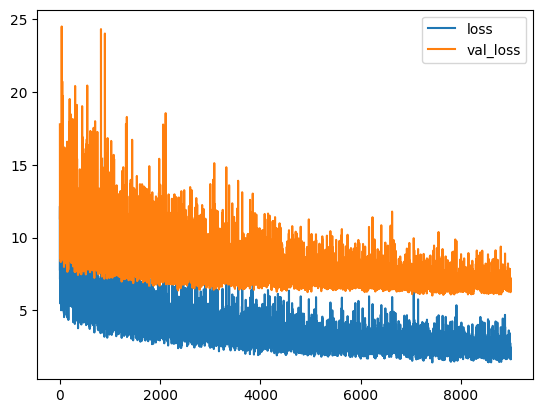

In [ ]:

print(history)
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [ ]:
# print(test_acc)

# cuda.select_device(0)
# cuda.close()


In [ ]:
model.save('out')

INFO:tensorflow:Assets written to: out\assets


INFO:tensorflow:Assets written to: out\assets
